In [1]:
! pip install sklearn_crfsuite
! pip install nltk
! pip install joblib


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [16]:
import nltk
from nltk.corpus import brown

In [54]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
from datasets import load_dataset

dataset = load_dataset("conll2003")

In [13]:
import sklearn
from sklearn_crfsuite import CRF, metrics

import joblib
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score

In [17]:
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /home/oddity/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/oddity/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [18]:
tagged_sentences = brown.tagged_sents(tagset='universal')

In [19]:
tagged_sentences[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

In [58]:
train_data = dataset['train']
validation_data = dataset['validation']
test_data = dataset['test']

sents = []

for data in train_data:
  temp = []
  for idx, word in enumerate(data['tokens']):
    temp.append((word, f'{data['pos_tags'][idx]}'))
  sents.append(temp)   

for data in validation_data:
  temp = []
  for idx, word in enumerate(data['tokens']):
    temp.append((word, f'{data['pos_tags'][idx]}'))
  sents.append(temp)   

for data in test_data:
  temp = []
  for idx, word in enumerate(data['tokens']):
    temp.append((word, f'{data['pos_tags'][idx]}'))
  sents.append(temp)   

In [59]:
sents[1000]

[('Australian', '16'),
 ('coach', '21'),
 ('Geoff', '22'),
 ('Marsh', '22'),
 ('said', '38'),
 ('he', '28'),
 ('was', '38'),
 ('impressed', '40'),
 ('with', '15'),
 ('the', '12'),
 ('competitiveness', '21'),
 ('of', '15'),
 ('the', '12'),
 ('opposition', '21'),
 ('.', '7')]

In [60]:
train_data[0]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

In [61]:
tagged_sentences = sents
tagged_sentences[0]

[('EU', '22'),
 ('rejects', '42'),
 ('German', '16'),
 ('call', '21'),
 ('to', '35'),
 ('boycott', '37'),
 ('British', '16'),
 ('lamb', '21'),
 ('.', '7')]

In [62]:
# Extract words and tags
tagged_words = [(word.lower(), tag) for sentence in tagged_sentences for (word, tag) in sentence]
words, tags = zip(*tagged_words)

In [63]:
unique_tags = set(tags) # Get all the distinct tags present in the dataset
print("No. of unique tags in the Brown corpus: ", len(unique_tags))

No. of unique tags in the Brown corpus:  45


In [64]:
# Display all the unique tags
unique_tags


{'0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '5',
 '6',
 '7',
 '8'}

In [65]:
len(words), len(tags) # Get the length of the words to be tagged in the Brown corpus dataset

(301418, 301418)

In [66]:
# Convert tagged sentences into a list of (word, tag) pairs
def get_sentences_with_features(tagged_sentences):
    def word2features(sent, i):
        word = sent[i][0]
        features = {
            'bias': 1.0,
            'word.lower()': word.lower(),
            'word[-3:]': word[-3:],
            'word[-2:]': word[-2:],
            'word.isupper()': word.isupper(),
            'word.istitle()': word.istitle(),
            'word.isdigit()': word.isdigit(),
        }
        if i > 0:
            word1 = sent[i - 1][0]
            features.update({
                '-1:word.lower()': word1.lower(),
                '-1:word.istitle()': word1.istitle(),
                '-1:word.isupper()': word1.isupper(),
            })
        else:
            features['BOS'] = True  # Beginning of Sentence

        if i < len(sent) - 1:
            word1 = sent[i + 1][0]
            features.update({
                '+1:word.lower()': word1.lower(),
                '+1:word.istitle()': word1.istitle(),
                '+1:word.isupper()': word1.isupper(),
            })
        else:
            features['EOS'] = True  # End of Sentence

        return features

    return [
        ([word2features(sent, i) for i in range(len(sent))], [tag for word, tag in sent])
        for sent in tagged_sentences
    ]

In [67]:
# Initialize the CRF model
pos_tagger = CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100, all_possible_transitions=True)

In [68]:

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
sentences_with_features = get_sentences_with_features(tagged_sentences)
sentences_with_features = np.array(sentences_with_features, dtype=object)
y_true_all, y_pred_all = [], []

pos_tagger = CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100, all_possible_transitions=True) # Initialize the CRF model

for fold, (train_idx, test_idx) in enumerate(kfold.split(sentences_with_features)):
    train_sentences_with_features = sentences_with_features[train_idx]
    test_sentences_with_features = sentences_with_features[test_idx]

    # Train CRF
    X_train, X_test = [sent[0] for sent in train_sentences_with_features], [sent[0] for sent in test_sentences_with_features]
    y_train, y_test = [sent[1] for sent in train_sentences_with_features], [sent[1] for sent in test_sentences_with_features]

    pos_tagger.fit(X_train, y_train)

    y_pred = pos_tagger.predict(X_test)
    y_true = y_test  # Use the true labels from the test set



    # Update overall true and predicted lists
  

    y_true = np.array(y_true, dtype=object)
    y_pred = np.array(y_pred, dtype=object)

    # Calculate accuracy for the current fold
    '''
    accuracy = accuracy_score(y_true, y_pred)
    '''
    y_true_flat = []
    y_pred_flat = []

    for i in range(len(y_true)):
        for j in range(len(y_true[i])):
            y_true_flat.append(y_true[i][j])
            y_pred_flat.append(y_pred[i][j])
            y_true_all.append(y_true[i][j])
            y_pred_all.append(y_pred[i][j])

    accuracy = sklearn.metrics.accuracy_score(y_true_flat, y_pred_flat)
    print(f'Fold {fold + 1} Accuracy: {accuracy:.4f}')

    print(y_pred[0])
    print(y_true[0])

Fold 1 Accuracy: 0.9558
['22', '27', '21', '35', '12', '22', '22', '27', '16', '21', '22', '22', '38', '15', '22', '24', '20', '37', '21', '15', '24', '16', '15', '22', '15', '12', '16', '21', '38', '21', '7']
['22', '27', '21', '35', '12', '22', '22', '27', '16', '21', '22', '22', '38', '15', '22', '24', '20', '37', '21', '15', '24', '16', '15', '22', '15', '12', '16', '21', '38', '17', '7']
Fold 2 Accuracy: 0.9551
['22', '42', '16', '21', '35', '37', '16', '21', '7']
['22', '42', '16', '21', '35', '37', '16', '21', '7']
Fold 3 Accuracy: 0.9572
['0', '44', '28', '41', '35', '37', '30', '16', '15', '42', '46', '16', '24', '41', '39', '35', '37', '22', '27', '21', '6', '0', '22', '22', '22', '27', '21', '4', '22', '5', '21', '22', '22', '22', '38', '15', '22', '21', '7']
['0', '44', '28', '41', '35', '37', '30', '16', '15', '42', '46', '16', '24', '41', '39', '35', '37', '22', '27', '21', '6', '0', '22', '22', '22', '27', '22', '4', '22', '5', '21', '22', '22', '22', '38', '15', '22', '

In [69]:
joblib.dump(pos_tagger, 'crf_pos_tagger.joblib')

['crf_pos_tagger.joblib']

### Confusion Matrix and per POS tag accuracy

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

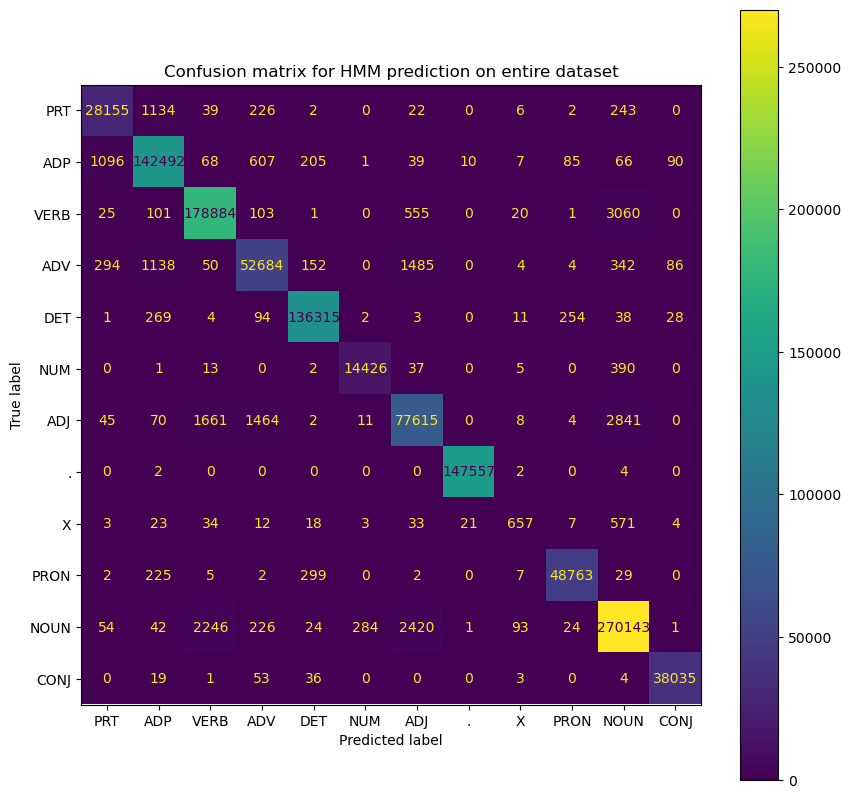

In [15]:
# Plot the confusion matrix

cm = confusion_matrix(y_true_all, y_pred_all, labels=list(unique_tags))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(unique_tags))
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
#disp.plot()
plt.title('Confusion matrix for HMM prediction on entire dataset')
plt.show()
